# Sparse Direct Solvers

## Introduction

So far we have considered iterative solvers for the solution of large linear systems of equations. These are efficient as long as the underlying linear operator is well conditioned or if there is an efficient preconditioner available.

We now want to return to direct solvers and consider how we can use them for the solution of large sparse linear systems of equations. We assume that we want to solve

$$
Ax=b
$$

with $A\in\mathbb{R}^{n\times n}$ a given sparse matrix and $b \in\mathbb{R}^n$ a right-hand side vector. While for iterative solvers we only needed the action of $A$ and therefore did not require an explicit representation. Here, we now require an explicit representation of $A$.

Let us review some basic facts on the direct solution of dense linear systems of equations.

## Solving dense linear systems of equations

The most frequently used method for solving dense linear systems of equations is the LU decomposition. The basic idea is to find a transform 

$$
PA = LU,
$$

where $P$ is a permutation matrix (each row and column consist of only one $1$ entry and zeros otherwise), $L$ is a lower triangular matrix with all ones on the diagonal, and $R$ is an upper triangular matrix.

This decomposition can be obtained through Gaussian Elimination. Below you find a very simple Python implementation of this method.

In [35]:
import numpy as np

def lu(A):
    """
    Implementation of a pivoted LU decomposition.
    
    Returns matrices P, L, U, such that
    PA = LU.
    """
    
    import numpy as np
    
    # Return an error if matrix is not square
    if not A.shape[0]==A.shape[1]:
        raise ValueError("Input matrix must be square")
        
    n = A.shape[0] # The number of rows/columns of A
    p = np.arange(n) # The permutation vector
    
    L = np.zeros((n,n),dtype='float64') # Reserve space for L
    U = np.zeros((n,n),dtype='float64') # Reserve space for U
    U[:] = A # Copy A into U as we do not want to modify A
    np.fill_diagonal(L,1) # fill the diagonal of L with 1
    
    for i in range(n-1):
        # The outer iteration
        # Permute the rows to ensure the element with largest magnitude is on top
        max_index = i+np.argmax(np.abs(U[i:,i]))
        U[[i,max_index],:] = U[[max_index,i],:]
        L[[i,max_index],:i] = L[[max_index,i],:i]
        p[[i,max_index]] = p[[max_index,i]]
        for j in range(i+1,n):
            L[j,i] = U[j,i]/U[i,i]
            U[j,i:] = U[j,i:]-L[j,i]*U[i,i:]
            U[j,i] = 0
    P = np.eye(n)[p,:] 
    return (P,L,U)


Let us try this out.

In [36]:
rand = np.random.RandomState(0)
n = 50
A = rand.randn(n, n)
P, L, U, = lu(A)
rel_residual = np.linalg.norm (P @ A - L @ U) / np.linalg.norm(A)
print(f"The relative residual is {rel_residual}.")

The relative residual is 4.889527314145724e-16.


The above implementation is quite straight forward. It uses Gaussian elimination to eliminate the entries below the diagonal in the current column and updates the rows accordingly. For numerical stability it applies partial pivoting. This strategy sorts the row with the largest (by magnitude) entry in the current column to the top of the current block.

Once we have the LU decomposition we can easily solve the linear system of equations $Ax = b$. We replace $PA = LU$ and obtain $LU = Pb$, which we solve in two steps. First we perform a forward substitution to solve the lower-triangular system $Ly = Pb$. Then we perform a backward substitution to solve the linear system $Ux = y$.

An example code is given below. Instead of implementing the triangular solve we use the corresponding method from Scipy.

In [37]:
from scipy.linalg import solve_triangular

b = rand.randn(n)
x = solve_triangular(
    U, solve_triangular(L, P @ b, lower=True))
print(f"Residual with partial pivot LU: {np.linalg.norm(b - A @ x) / np.linalg.norm(b)}.")


Residual with partial pivot LU: 1.7431488527611673e-14.


This is in principal what the `solve` commands in Numpy and Scipy are doing for dense linear system of equations. However, they use the corresponding Lapack routines, which are highly efficient cache-optimised implementations. **One should never use a custom LU implementation for dense systems, but always use the corresponding Lapack routines**. We have given the implementation above only for demonstrational purposes.

The complexity of dense LU decomposition is $\frac{2}{3}n^3 + \mathcal{O}(n^2)$. The forward and backward substitution have quadratic complexity. Hence, this method is without modification not suitable for large systems of equations.

## LU Decomposition for systems of equations with small bandwidth

Let us consider the example of the following tridiagonal matrix.

In [38]:
import numpy as np
from scipy.sparse import diags
n = 20

data = [4. * np.ones(n),
        -2. * np.ones(n - 1),
        -1. * np.ones(n - 1)]

offsets = [0, 1, -1]

A = diags(data, offsets=offsets, shape=(n, n), format='csr').todense()

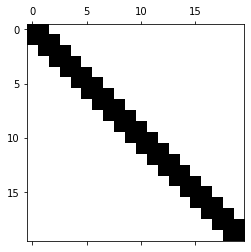

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.spy(A)

We compute the LU factors and visualize them.

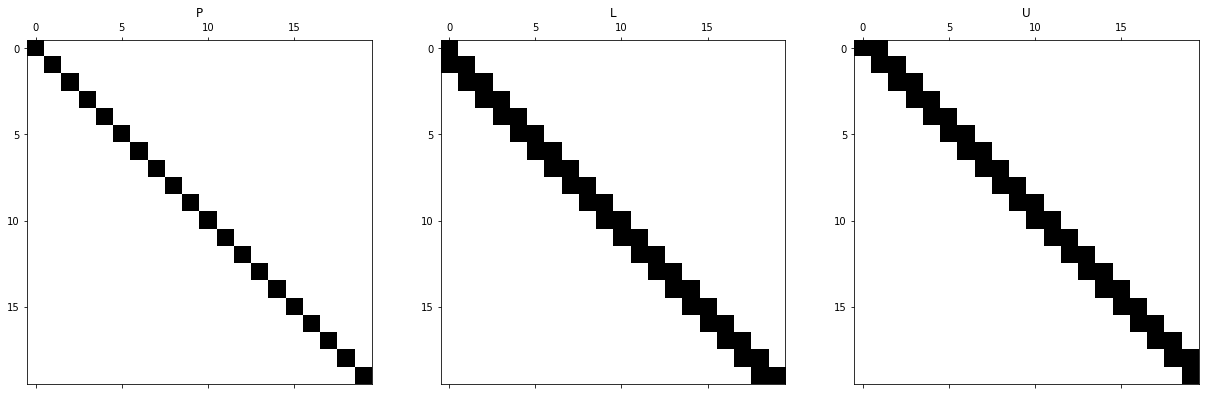

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.linalg import lu

P, L, U = lu(A)

fig = plt.figure(figsize = (21, 8))
ax1 = fig.add_subplot(131)
im1 = ax1.spy(P)
ax1.set_title('P')
ax2 = fig.add_subplot(132)
ax2.spy(L)
ax2.set_title('L')
ax3 = fig.add_subplot(133)
ax3.spy(U)
ax3.set_title('U');

The permutation matrix P is just the identity. The diagonal was chosen on purpose to achieve this and avoid reordering. We can see that while the original matrix was tridiagonal, the L matrix now is lower bidiagonal and the upper U matrix is upper bidiagonal. This is no coincidence. One can see quite easily from the way that Gaussian elimination proceeds that the bandwidth of a matrix remains constant. Let us make this statement precise.

**Banded matrix.** A matrix $A$ is called banded if there exists two nonnegative integers $m_U$ and $m_L$ such that $a_{ij} \neq 0$ only for $i-m_L\leq j\leq i + m_U$. The total bandwidth is given as $m=m_L + m_U + 1$.

Banded matrices have a wonderful property, namely the LU decomposition does not increase the bandwidth $m$. In particular, the lower bandwidth $m_L$ of $A$ is the same as the lower bandwidth of $L$ and the upper bandwidth $m_U$ of $A$ is the same as the upper bandwidth of $U$.

If we have a sequence of banded matrices $A_n$ with constant bandwidth (e.g. from the discretisation of a PDE with increasing numbers of discretisation points), the LU decomposition has linear complexity $O(n)$, where the factors in the $O$-notation depend on the bandwidth. Hence, LU decomposition is a highly efficient solver for problems with small bandwidth if the zero structure is taken into account, that is operations are avoided on entries that are known to be zero.

## Matrices with arrow structure

Another example of matrices, for which the LU decomposition is highly efficient, are matrices with certain arrow structures. Consider the following example.

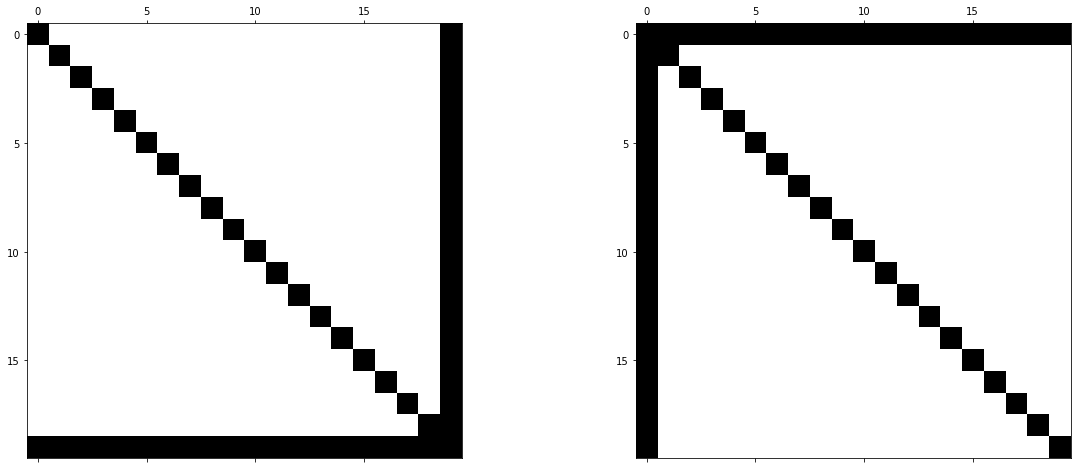

In [41]:
n = 20

A = np.diag(np.ones(n, dtype=np.float64))
A[-1, :] = .5
A[:, -1] = .5

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.spy(A)

reversal = np.flip(np.arange(n))
Apermuted = A[reversal, :][:, reversal]

ax2 = fig.add_subplot(122)
ax2.spy(Apermuted)


It is immediately clear that the left matrix has an efficient LU decomposition. We only need to reduce the last row via Gaussian elimination and we do not introduce any fill-in. On the other hand, the right-hand side matrix is a simple permutation of the left-matrix, obtained by relabelling the unknowns (e.g. $0\rightarrow 9$, $1\rightarrow 8$, etc.). Although the matrix is different now, the underlying linear system does not change in principle. The unknowns have just been relabelled and equation order changed. However, if we apply the LU decomposition to the right matrix, both $L$ and $U$ will fill up completely.

## Reordering methods for sparse Gaussian Elimination

In practice, the difficulty with sparse direct solvers is to achieve a reordering that minimizes fill-in (that is creation of new nonzero elements) from the LU decomposition applied to the sparse matrix. Over time a number of heuristic reordering methods have been developed that aim to reduce the fill-in during the Gaussian Elimination phase, such as Cuthil-McKeee, Reverse Cuthill-McKee or Minimal Degree Reorderings. Most sparse solvers include reordering steps by default. So it is rarely necessary to think about it. But sometimes it may be necessary to squeeze out slightly better performance by changing the reordering method.

## Limits of sparse direct solvers

The performance of sparse direct solvers strongly depends on the adjacency graph (the adjacency graph is a representation of the connnectivity in the sparse matrix). Generally, for one dimensional and many two dimensional PDE discretisations sparse direct solvers can be used very efficiently. Usually, the heuristic reordering methods do a good job of minimizing fill-in with good results for the overall time and memory complexity. Three-dimensional PDE discretisations can be more problematic. In three dimensions we have significantly more intricate connectivity between unknowns and sparse direct solvers quickly become infeasible even with good reordering.

## Incomplete LU Decomposition

It is possible to combine ideas from the LU decomposition and iterative solvers. If a complete LU decomposition is too expensive we may still be able to perform an incomplete LU decomposition. The idea is to heuristically reduce the generated fill-in through the course of the LU decomposition by using a dropping criterion. The difficulty with the incomplete LU decomposition is that it may lead to a singular approximate decomposition. In the following example we use the ILU applied to the matrix $A$ from the `discretise_poisson` example to demonstrate how it can be used as a preconditioner.

In [43]:
import numpy as np
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

The following code solves the Poisson problem with $N=100$ using GMRES, once with preconditioning and once without preconditioning.

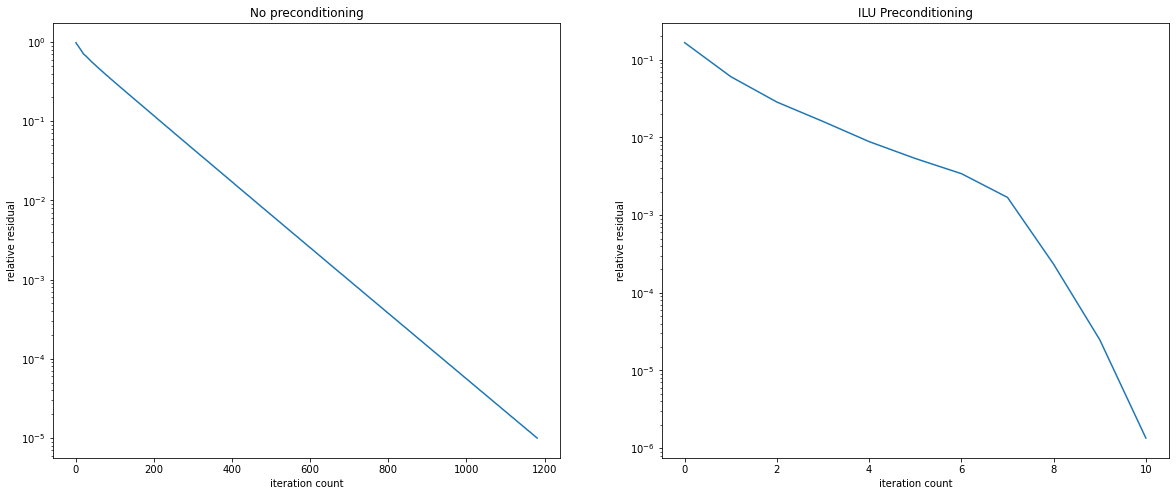

In [46]:
from scipy.sparse.linalg import spilu, LinearOperator, gmres

N = 100
A, f = discretise_poisson(N)

M = LinearOperator(matvec=spilu(A, fill_factor=20, drop_rule='dynamic').solve,
                   shape=(N**2, N**2), 
                   dtype=np.float64)

residuals1 = []
callback1 = lambda res: residuals1.append(res) 
x, _ = gmres(A, f, callback=callback1, callback_type='pr_norm')


residuals2 = []
callback2 = lambda res: residuals2.append(res) 
x, _ = gmres(A, f, M=M, callback=callback2, callback_type='pr_norm')

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.semilogy(residuals1)
ax1.set_title('No preconditioning')
ax1.set_xlabel('iteration count')
ax1.set_ylabel('relative residual')

ax2 = fig.add_subplot(122)
ax2.semilogy(residuals2)
ax2.set_title('ILU Preconditioning')
ax2.set_xlabel('iteration count')
ax2.set_ylabel('relative residual');

ILU Preconditioning has lead to a dramatic improvement. We now convergence in just 10 iterations. However, generating the ILU Preconditioner can be tricky as it easily leads to a singular incomplete factorisation.
For certain classes of problems good ILU strategies are known and have been analysed. Then, ILU is an excellent and powerful tool to combine ideas from direct and iterative solvers.